# Maintenance du modele

In [87]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import decomposition
from sklearn.metrics.cluster import adjusted_rand_score 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from datetime import timedelta




from sklearn.metrics import adjusted_rand_score
from IPython.display import display

**Indice de Rand ajusté (ARI)** : Cette mesure compare les clusters obtenus avec les véritables étiquettes de classe. Un ARI de 1 indique que les clusters correspondent parfaitement aux véritables classes.

Ce notebook se concentre sur la maintenance du modèle KMeans avec 4 clusters sélectionnés. L'évaluation de l'ARI sera effectuée sur les 3 derniers mois, du 28-05-2018 au 28-08-2018, par rapport au modèle de référence démarré le 01-01-2017.

In [88]:
# chargement des donées
df = pd.read_csv('Data/df_f.csv')
display(df.head())

,customer_unique_id,customer_id,achat_moy,total_purchase_value,note,payment_type,customer_city,customer_state,order_purchase_timestamp,last_purchase,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,129.90,5.0,credit_card,cajamar,SP,2018-05-10 10:56:27,111.0,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,18.90,4.0,credit_card,osasco,SP,2018-05-07 11:11:27,114.0,health_beauty
2,0000f46a3911fa3c0805444483337064,1,69.00,69.00,3.0,credit_card,sao jose,SC,2017-03-10 21:05:03,536.0,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,25.99,4.0,credit_card,belem,PA,2017-10-12 20:29:41,320.0,telephony
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,180.00,5.0,credit_card,sorocaba,SP,2017-11-14 19:45:42,287.0,telephony


In [89]:
#Renomer les colonnes
df = df[['customer_unique_id', 'customer_id','achat_moy', 'last_purchase', 'note', 'order_purchase_timestamp']]
display(df.head())
df.rename(columns={ 'customer_id': 'frequency', 'achat_moy': 'monetary', 'last_purchase': 'recency', 'note': 'note'}, inplace=True)
df.head()

,customer_unique_id,customer_id,achat_moy,last_purchase,note,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,111.0,5.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,114.0,4.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,69.00,536.0,3.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,320.0,4.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,287.0,5.0,2017-11-14 19:45:42


,customer_unique_id,frequency,monetary,recency,note,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,111.0,5.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,114.0,4.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,69.00,536.0,3.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,320.0,4.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,287.0,5.0,2017-11-14 19:45:42


In [90]:
# Supprimer la colonne customer_unique_id
df.drop("customer_unique_id", axis = 1,inplace = True)
display(df.head())
print("Date du dernier achat", df.order_purchase_timestamp.max())
print("Date du premier achat", df.order_purchase_timestamp.min())
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

,frequency,monetary,recency,note,order_purchase_timestamp
0,1,129.90,111.0,5.0,2018-05-10 10:56:27
1,1,18.90,114.0,4.0,2018-05-07 11:11:27
2,1,69.00,536.0,3.0,2017-03-10 21:05:03
3,1,25.99,320.0,4.0,2017-10-12 20:29:41
4,1,180.00,287.0,5.0,2017-11-14 19:45:42


Date du dernier achat 2018-08-29 15:00:37
Date du premier achat 2016-10-03 16:56:50


### Calcule du score ARI

In [91]:

start_date = dt.datetime(2017, 1, 1, 0, 0)
start_T0 = dt.datetime(2018, 5, 28, 0, 0)

mask_F0 = (df['order_purchase_timestamp'] > start_date) & (
    df['order_purchase_timestamp'] <= start_T0)
data_init = df.loc[mask_F0].drop(columns='order_purchase_timestamp')

# Kmean sur la période initiale
kmeans_init = Pipeline([("preprocessor", StandardScaler()),
                        ("kmeans", KMeans(n_clusters=4, n_init=1, init='k-means++', max_iter=100, random_state=1))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [92]:
# Initialiser une liste pour stocker les scores ARI
ari_score = []

# Boucle sur la periode
for p in range(1, 90, 6):
    # Définir les dates de début pour les périodes
    start_date = dt.datetime(2017, 1, 1, 0, 0)
    start_T0 = dt.datetime(2018, 5, 28, 0, 0)
    

    # Calculer la date de fin de chaque période
    start_date_Tp = start_T0 + timedelta(days=p)

    # Créer une copie des données
    data_period = df.copy()

    #  sélectionner les données dans la période de temps définie
    mask_data_period = (df['order_purchase_timestamp'] > start_date) & (
        df['order_purchase_timestamp'] <= start_date_Tp)

    # Sélectionner les données pour la période de temps définie
    data_period = df.loc[mask_data_period].drop(
        columns='order_purchase_timestamp')
    # Standardiser les données
    preprocessor = ColumnTransformer(
        [('scaler', StandardScaler(), data_period.columns)])

    kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                         ("kmeans", KMeans(n_clusters=4, n_init=1, init='k-means++', max_iter=100, random_state=1))])

    # Ajuster le pipeline aux données de la période
    kmeans_p.fit(data_period)

    # Obtenir les étiquettes de cluster pour les données de la période
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calculer le score ARI 
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))


    ari_score.append([p, round(ari_p,2)])
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])
print("Nombre de jours dans une periode", p/len(ari_score))
print(ari_score)

Nombre de jours dans une periode 5.666666666666667
    periode   ARI
0         1  0.98
1         7  0.98
2        13  0.82
3        19  0.37
4        25  0.91
5        31  0.83
6        37  0.59
7        43  0.89
8        49  0.88
9        55  0.36
10       61  0.84
11       67  0.73
12       73  0.64
13       79  0.69
14       85  0.67


2018-05-28 00:00:00


/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


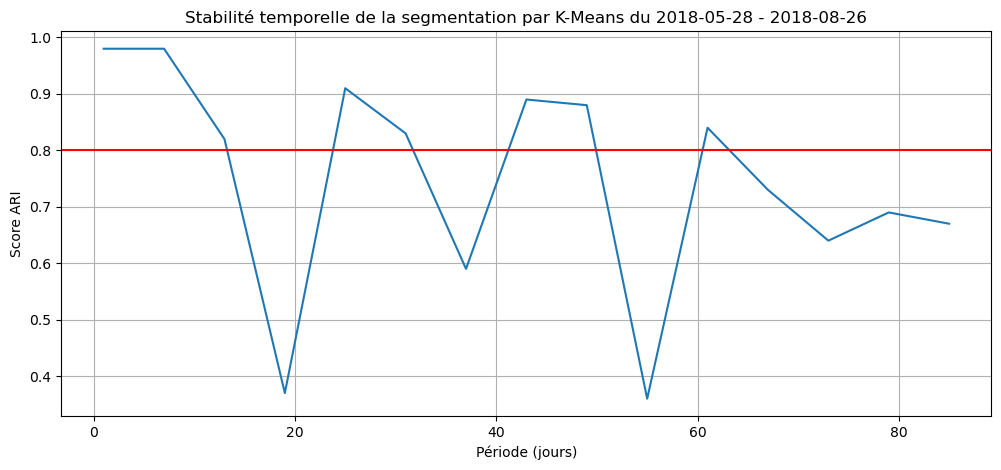

In [93]:

# plot ARI Score
fig = plt.figure(figsize=(12, 5))
print(start_T0)
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means du " + start_T0.strftime('%Y-%m-%d') + ' - ' + (start_T0 + timedelta(days=90)).strftime('%Y-%m-%d')) 
#plt.title( "Stabilité temporelle de la segmentation par K-Means du"+ str(start_T0) +'-' +str(start_T0 + timedelta(days=90))) 
plt.axhline(y=0.8, color='r', linestyle='-')
plt.grid(True)
plt.show()

 Conclusion
 le score ARI chute à 0.81 au bout du 13ème jour. Cette baisse de performance peut être attribuée à l'évolution constante des données, ce qui peut entraîner des modifications dans la structure des clusters. Par conséquent, afin de garantir une segmentation précise des données, il est recommandé d'actualiser le modèle environ tous les 12 jours. Cette fréquence d'actualisation nous permettra de suivre de près les changements dans les comportements des clients ou les tendances du marché,